A fully-connected neural network does a pretty good job here, because the spatial structure of the images is fairly simple.

pytorch on CPU

In [1]:
! pip install torch torchvision

pytorch on GPU

need for an older numpy version to use with the old pytorch version below (which is needed for GPU usage on my machine)

In [2]:
# ! pip install numpy==1.26.4

to use your GPU via CUDA:
- run the command nvidia-smi on terminal to find out your CUDA version, e.g., 11.6
- install the corresponding pytorch wheel (check here: https://pytorch.org/get-started/previous-versions/)
- need for a fitting python version (3.10 in my case)

In [3]:
# ! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [4]:
! pip install matplotlib
! pip install torcheval

In [5]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import MulticlassAccuracy
import numpy as np
import matplotlib.pyplot as plt

check for GPU and use it if available

In [6]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_pytorch = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_pytorch

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
mnist_pytorch.data.shape

torch.Size([60000, 28, 28])

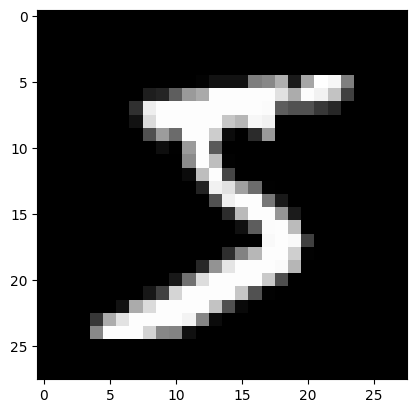

In [9]:
plt.imshow(mnist_pytorch.data[0], cmap='gray', vmin=0, vmax=255)

In [10]:
mnist_pytorch.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

convert to one-hot targets for multi-classification

In [11]:
target_tensor = torch.nn.functional.one_hot(mnist_pytorch.targets).to(dtype=torch.float32).to(device)
target_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0')

need to flatten 2D structure of image for fully-connected neural network

In [12]:
input_tensor = torch.flatten(mnist_pytorch.data, start_dim=1).to(dtype=torch.float32).to(device)

In [13]:
input_ds = torch.utils.data.TensorDataset(input_tensor, target_tensor)

split data in training and test sets

In [14]:
train_ds, test_ds = torch.utils.data.random_split(input_ds, [0.8, 0.2])

further split training set in training and validation sets

In [15]:
train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.9, 0.1])

In [16]:
mini_batch_size = 512

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True, drop_last=False)
valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=mini_batch_size * 2)

In [17]:
class FCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(784, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10)
        )

    def forward(self, X):
        X = self.fcn(X)
        return X

In [18]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters())

number of trainable model parameters

In [19]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

573910

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [21]:
early_stopping = EarlyStopping(patience=5, delta=0.01)

In [22]:
def fit(epochs, model, optimizer, train_dl, valid_dl=None):
    loss_func = torch.nn.CrossEntropyLoss()

    # loop over epochs
    for epoch in range(epochs):
        model.train()

        # loop over mini-batches
        for X_mb, y_mb in train_dl:
            y_hat = model(X_mb)

            loss = loss_func(y_hat, y_mb)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in train_dl)
            valid_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in valid_dl)
        print('epoch {}, training loss {}'.format(epoch + 1, train_loss / len(train_dl)))
        print('epoch {}, validation loss {}'.format(epoch + 1, valid_loss / len(valid_dl)))

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('Finished training')

    return model

In [23]:
epochs = 50

trained_model = fit(epochs, model, optimizer, train_dl, valid_dl)

epoch 1, training loss 0.1544477790594101
epoch 1, validation loss 0.1812233179807663
epoch 2, training loss 0.0928589329123497
epoch 2, validation loss 0.12856009602546692
epoch 3, training loss 0.05124674364924431
epoch 3, validation loss 0.10469061136245728
epoch 4, training loss 0.03552326560020447
epoch 4, validation loss 0.09947766363620758
epoch 5, training loss 0.025007445365190506
epoch 5, validation loss 0.09156404435634613
epoch 6, training loss 0.020626362413167953
epoch 6, validation loss 0.09851621091365814
epoch 7, training loss 0.013621065765619278
epoch 7, validation loss 0.08767042309045792
epoch 8, training loss 0.018241673707962036
epoch 8, validation loss 0.11135579645633698
epoch 9, training loss 0.02093401923775673
epoch 9, validation loss 0.11767499893903732
epoch 10, training loss 0.01257068756967783
epoch 10, validation loss 0.10572492331266403
epoch 11, training loss 0.022058121860027313
epoch 11, validation loss 0.12896354496479034
epoch 12, training loss 0.

In [24]:
early_stopping.load_best_model(model)

In [25]:
def evaluation(ds, model):
    with torch.no_grad():
        preds = model(ds[:][0]).cpu()

    # take output node with highest probability
    yhat = np.argmax(preds, axis=1)
    y = ds[:][1].cpu()

    # from one-hot back to labels
    y = torch.argmax(y, dim=1)

    metric = MulticlassAccuracy()

    metric.update(yhat, y)
    return metric.compute()

In [26]:
evaluation(train_ds, trained_model)

tensor(0.9969)

In [27]:
evaluation(test_ds, trained_model)

tensor(0.9732)